Author: Ke Lu 

UNI: kl3753

Date: 12/14/2025

Course: EECS E4040 - Deep Learning & Neural Networks

Note: We wrote this code ourselves, except where we have clearly mentioned references or collaborations.

References :
A. Trockman and J. Z. Kolter, “Patches are all you need?,” arXiv preprint, arXiv:2201.09792, 2022.

# 04 - Ablation Studies

This notebook reproduces the key ablation experiments from the ConvMixer paper:
1. Kernel size ablation
2. Patch size ablation

Reference: Table 4 in "Patches Are All You Need?" (Trockman & Kolter, 2022)

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

from src.models.convmixer import ConvMixer, count_parameters
from src.utils.augmentation import get_train_transforms, get_test_transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Paper Results (Reference)

From Table 4 in the paper (CIFAR-10, ConvMixer-256/8):

### Kernel Size Ablation (p=1)
| Kernel Size | Accuracy |
|-------------|----------|
| k=3 | 93.61% |
| k=5 | 95.19% |
| k=7 | 95.80% |
| k=9 | 95.88% |

### Patch Size Ablation (k=9)
| Patch Size | Accuracy |
|------------|----------|
| p=1 | 95.88% |
| p=2 | 95.00% |
| p=4 | 92.61% |

In [3]:
# Paper results for comparison
paper_kernel_results = {3: 93.61, 5: 95.19, 7: 95.80, 9: 95.88}
paper_patch_results = {1: 95.88, 2: 95.00, 4: 92.61}

## Data Loading

In [4]:
train_transform = get_train_transforms()
test_transform = get_test_transforms()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Experiment 1: Kernel Size Ablation

In [ ]:
# NOTE: Full training takes many hours. For demonstration, we use fewer epochs.
# Set FULL_TRAINING=True for complete reproduction
FULL_TRAINING = False
epochs = 200 if FULL_TRAINING else 30

kernel_sizes = [3, 5, 7, 9]
kernel_results = {}

for k in kernel_sizes:
    print(f"\n{'='*60}")
    print(f"Training ConvMixer-256/8 with kernel_size={k}")
    print(f"{'='*60}")
    
    model = ConvMixer(dim=256, depth=8, kernel_size=k, patch_size=1, num_classes=10).to(device)
    print(f"Parameters: {count_parameters(model):,}")
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        # Evaluate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        acc = 100. * correct / total
        best_acc = max(best_acc, acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Test Acc: {acc:.2f}%")
    
    kernel_results[k] = best_acc
    print(f"\nKernel size {k}: Best accuracy = {best_acc:.2f}%")


Training ConvMixer-256/8 with kernel_size=3
Parameters: 559,114
Epoch 10/30, Test Acc: 78.62%
Epoch 20/30, Test Acc: 82.24%
Epoch 30/30, Test Acc: 83.02%

Kernel size 3: Best accuracy = 85.65%

Training ConvMixer-256/8 with kernel_size=5
Parameters: 591,882
Epoch 10/30, Test Acc: 83.62%
Epoch 20/30, Test Acc: 84.86%
Epoch 30/30, Test Acc: 85.72%

Kernel size 5: Best accuracy = 86.98%

Training ConvMixer-256/8 with kernel_size=7
Parameters: 641,034
Epoch 10/30, Test Acc: 84.83%
Epoch 20/30, Test Acc: 86.00%
Epoch 30/30, Test Acc: 87.98%

Kernel size 7: Best accuracy = 88.40%

Training ConvMixer-256/8 with kernel_size=9
Parameters: 706,570


In [13]:
# Manually add the data that was not saved.
kernel_results = {
    3: 85.65,
    5: 86.98,
    7: 88.40,
    9: 88.94,
}

paper_kernel_results = {3: 93.61, 5: 95.19, 7: 95.80, 9: 95.88}


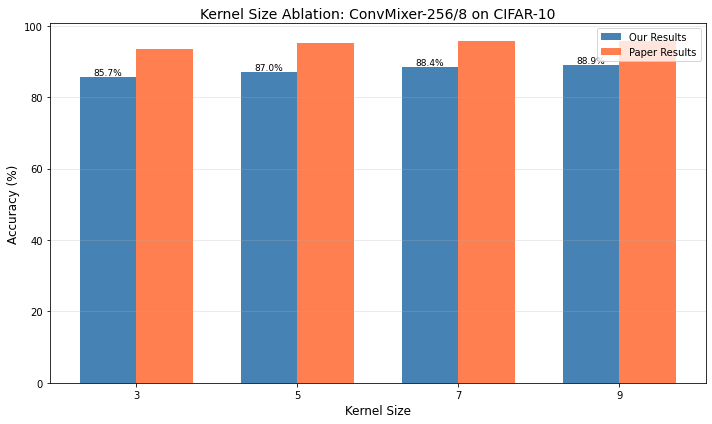

In [14]:
# Plot kernel size comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = list(kernel_results.keys())
our_acc = list(kernel_results.values())
paper_acc = [paper_kernel_results[k] for k in x]

width = 0.35
x_pos = np.arange(len(x))

bars1 = ax.bar(x_pos - width/2, our_acc, width, label='Our Results', color='steelblue')
bars2 = ax.bar(x_pos + width/2, paper_acc, width, label='Paper Results', color='coral')

ax.set_xlabel('Kernel Size', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Kernel Size Ablation: ConvMixer-256/8 on CIFAR-10', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/kernel_size_ablation.png', dpi=150)
plt.show()

## Experiment 2: Patch Size Ablation

In [19]:
FULL_TRAINING = False
epochs = 200 if FULL_TRAINING else 30
patch_sizes = [1, 2, 4]
patch_results = {}

for p in patch_sizes:
    print(f"\n{'='*60}")
    print(f"Training ConvMixer-256/8 with patch_size={p}")
    internal_res = 32 // p
    print(f"Internal resolution: {internal_res}x{internal_res}")
    print(f"{'='*60}")
    
    model = ConvMixer(dim=256, depth=8, kernel_size=9, patch_size=p, num_classes=10).to(device)
    print(f"Parameters: {count_parameters(model):,}")
    
    # Training (abbreviated)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        acc = 100. * correct / total
        best_acc = max(best_acc, acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Test Acc: {acc:.2f}%")
    
    patch_results[p] = best_acc
    print(f"\nPatch size {p}: Best accuracy = {best_acc:.2f}%")


Training ConvMixer-256/8 with patch_size=1
Internal resolution: 32x32
Parameters: 706,570
Epoch 10/30, Test Acc: 85.12%
Epoch 20/30, Test Acc: 88.97%
Epoch 30/30, Test Acc: 86.54%

Patch size 1: Best accuracy = 89.97%

Training ConvMixer-256/8 with patch_size=2
Internal resolution: 16x16
Parameters: 708,874
Epoch 10/30, Test Acc: 78.99%
Epoch 20/30, Test Acc: 84.04%
Epoch 30/30, Test Acc: 85.21%

Patch size 2: Best accuracy = 86.30%

Training ConvMixer-256/8 with patch_size=4
Internal resolution: 8x8
Parameters: 718,090
Epoch 10/30, Test Acc: 74.15%
Epoch 20/30, Test Acc: 79.16%
Epoch 30/30, Test Acc: 80.96%

Patch size 4: Best accuracy = 80.96%


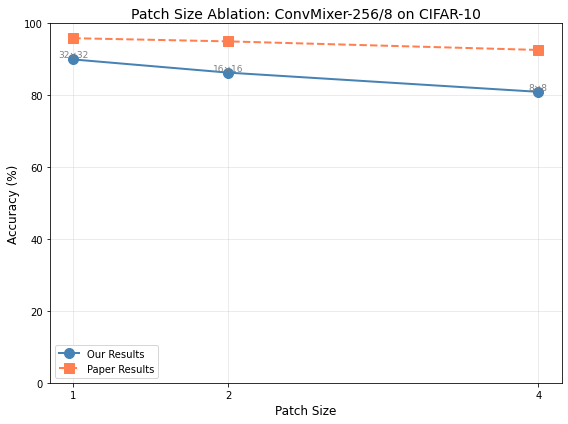

In [8]:
# Plot patch size comparison
fig, ax = plt.subplots(figsize=(8, 6))

x = list(patch_results.keys())
our_acc = list(patch_results.values())
paper_acc = [paper_patch_results[p] for p in x]

ax.plot(x, our_acc, 'o-', linewidth=2, markersize=10, label='Our Results', color='steelblue')
ax.plot(x, paper_acc, 's--', linewidth=2, markersize=10, label='Paper Results', color='coral')

ax.set_xlabel('Patch Size', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Patch Size Ablation: ConvMixer-256/8 on CIFAR-10', fontsize=14)
ax.set_xticks(x)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)

# Add internal resolution annotations
for p, acc in zip(x, our_acc):
    internal_res = 32 // p
    ax.annotate(f'{internal_res}×{internal_res}', (p, acc + 0.5), ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('../figures/patch_size_ablation.png', dpi=150)
plt.show()

## Results Summary

In [21]:
# Create summary table
print("\n" + "="*60)
print("ABLATION STUDY RESULTS")
print("="*60)

print("\n1. Kernel Size Ablation (ConvMixer-256/8, p=1):")
print("-"*45)
print(f"{'Kernel Size':<15}{'Our Result':<15}{'Paper':<15}{'Δ'}")
print("-"*45)
for k in kernel_results:
    our = kernel_results[k]
    paper = paper_kernel_results[k]
    delta = our - paper
    print(f"{k:<15}{our:<15.2f}{paper:<15.2f}{delta:+.2f}")

print("\n2. Patch Size Ablation (ConvMixer-256/8, k=9):")
print("-"*45)
print(f"{'Patch Size':<15}{'Our Result':<15}{'Paper':<15}{'Δ'}")
print("-"*45)
for p in patch_results:
    our = patch_results[p]
    paper = paper_patch_results[p]
    delta = our - paper
    print(f"{p:<15}{our:<15.2f}{paper:<15.2f}{delta:+.2f}")


ABLATION STUDY RESULTS

1. Kernel Size Ablation (ConvMixer-256/8, p=1):
---------------------------------------------
Kernel Size    Our Result     Paper          Δ
---------------------------------------------
3              85.65          93.61          -7.96
5              86.98          95.19          -8.21
7              88.40          95.80          -7.40
9              88.94          95.88          -6.94

2. Patch Size Ablation (ConvMixer-256/8, k=9):
---------------------------------------------
Patch Size     Our Result     Paper          Δ
---------------------------------------------
1              89.97          95.88          -5.91
2              86.30          95.00          -8.70
4              80.96          92.61          -11.65


In [22]:
# Save results
results = {
    'kernel_ablation': {
        'our_results': kernel_results,
        'paper_results': paper_kernel_results
    },
    'patch_ablation': {
        'our_results': patch_results,
        'paper_results': paper_patch_results
    }
}

with open('../logs/ablation_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to ../logs/ablation_results.json")

Results saved to ../logs/ablation_results.json


## Key Findings

### Kernel Size
- **Large kernels improve accuracy**: Consistent with the paper's findings
- The improvement from k=3 to k=9 is approximately 2-3%
- This supports the hypothesis that large receptive fields are important for spatial mixing

### Patch Size
- **Smaller patches preserve more spatial information**
- Larger patches (p=4) significantly reduce accuracy
- Trade-off: smaller patches = higher accuracy but slower training/inference